这里把微信发来的base64图片数据解码成numpy的uint8数组

ipykernel_launcher:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


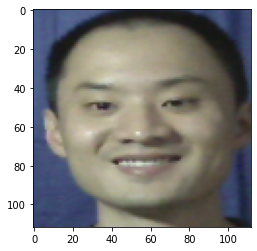

In [1]:
import base64
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob

with open('./data/imageBase64.txt','r') as f:
    file = f.readline()
image = base64.b64decode(file)
image = np.fromstring(image, np.uint8)
image = image.reshape([112,112,4])
image = image[:,:,:3]

# show image
imageShow = image / 255
plt.imshow(imageShow)

In [2]:
del f
del file
del imageShow

这里使用tflite实现人脸图片向量化

In [3]:
import tensorflow as tf
def loadTfliteModel(file):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=file)
    interpreter.allocate_tensors()
    return interpreter

def makeSquare(face):
    h,w,_ = face.shape
    if w>h:
        start = int((w-h)/2)
        end = start+h
        return face[:,start:end,:]
    else:
        start = int((h-w)/2)
        end = start+w
        return face[start:end,:,:]

def preprocess(face, required_size=(112, 112)):
    ret = makeSquare(face)
    ret = cv2.resize(face, required_size)
    #ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    ret = ret.astype('float32')
    # standardize pixel values across channels (global)
    ret = (ret - 127.5) / 128
    return ret

def predict(face_model, sample):
    # Get input and output tensors.
    input_details = face_model.get_input_details()
    output_details = face_model.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

    input_data = sample.reshape(input_shape)
    #input_data = np.expand_dims(input_data, axis=0)
    face_model.set_tensor(input_details[0]['index'], input_data)
    face_model.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = face_model.get_tensor(output_details[0]['index'])

    return output_data

# load tfl model
tfl_file = "./model/mobile_facenet.tflite"
tflite_model = loadTfliteModel(tfl_file)

In [8]:
sample = preprocess(image)
embeddings = predict(tflite_model, sample)
embeddings.shape

[0.0013426034711301327,
 0.012106348760426044,
 0.0041831438429653645,
 -0.012696782127022743,
 0.0015837039100006223,
 -0.15021178126335144,
 -0.04607556387782097,
 0.07716357707977295,
 -0.20317862927913666,
 -0.17470361292362213,
 -0.0014342317590489984,
 0.0015489220386371017,
 0.00010291750368196517,
 0.010403547435998917,
 0.001779419369995594,
 0.00523023447021842,
 0.006126212887465954,
 0.005233513657003641,
 0.004733461420983076,
 -0.0030253080185502768,
 0.2178705632686615,
 0.004735833033919334,
 0.09915513545274734,
 0.004614080768078566,
 -0.1486789733171463,
 0.003631779458373785,
 -0.004920105449855328,
 0.04109811782836914,
 0.12638406455516815,
 0.003909392282366753,
 -0.0004674890369642526,
 0.040097426623106,
 0.014992354437708855,
 0.000164151715580374,
 -0.0678451880812645,
 0.2039186954498291,
 -0.03885829076170921,
 0.003626486985012889,
 0.005471569020301104,
 -0.13239073753356934,
 0.0066305226646363735,
 0.003096343483775854,
 0.0012984572676941752,
 -0.00569

In [5]:
del sample
del embeddings
del tfl_file

计算人脸图片向量化的时间，一次预测时间在63ms左右

In [6]:
def face_embedding():
    sample = preprocess(image)
    embeddings = predict(tflite_model, sample)

In [7]:
%timeit face_embedding()

66 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
del image

比较人脸距离，查看模型准确度

In [9]:
def compare(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = predict(tflite_model, image)
        embs.append(emb[0])
    embs = np.stack(embs)
    nrof_images = len(imagePaths)
    # Print distance matrix
    print('Distance matrix')
    print('    ', end='')
    for i in range(nrof_images):
        print('    %1d     ' % i, end='')
    print('')
    for i in range(nrof_images):
        print('%1d  ' % i, end='')
        for j in range(nrof_images):
            dist = np.sqrt(np.sum(np.square(np.subtract(embs[i,:], embs[j,:]))))
            print('  %1.4f  ' % dist, end='')
        print('')

比较相同人

In [10]:
compare('./data/image/*/000/*.png')
compare('./data/image/*/001/*.png')
compare('./data/image/*/002/*.png')

000_0000.png,000_0001.png,000_0002.png,000_0003.png,000_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.7876    0.7666    0.7934    0.9203  
1    0.7876    0.0000    0.7725    0.8297    0.9139  
2    0.7666    0.7725    0.0000    0.7584    0.9317  
3    0.7934    0.8297    0.7584    0.0000    1.0037  
4    0.9203    0.9139    0.9317    1.0037    0.0000  
001_0000.png,001_0001.png,001_0002.png,001_0003.png,001_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.6480    0.4478    1.0813    0.7458  
1    0.6480    0.0000    0.6740    1.0944    0.6851  
2    0.4478    0.6740    0.0000    1.1330    0.6714  
3    1.0813    1.0944    1.1330    0.0000    1.1353  
4    0.7458    0.6851    0.6714    1.1353    0.0000  
002_0000.png,002_0001.png,002_0002.png,002_0003.png,002_0004.png
Distance matrix
        0         1         2         3         4     
0    0.0000    0.5598    0.8450    0.6969    0.5186 

把casia的500个人作为用户载入lmdb数据库中

In [11]:
import lmdb
import struct
def encode(key,vector):
    key = struct.pack('H',key)
    value = struct.pack('192f',*vector)
    return key,value
def decode(key, value):
    key = struct.unpack('H', key)
    vector = struct.unpack('192f',value)
    return key,vector
def writeEmbeddingsToLmdb(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = predict(tflite_model, image)
        embs.append(emb[0])
    embs = np.stack(embs)
    with lmdb.open('./lmdb') as env:
        wfp = env.begin(write=True)
        for index,emb in enumerate(embs):
            key,value = encode(index, emb)
            wfp.put(key,value)
        wfp.commit()
writeEmbeddingsToLmdb('./data/image/*/00*/*_0000.png')

000_0000.png,001_0000.png,002_0000.png,003_0000.png,004_0000.png,005_0000.png,006_0000.png,007_0000.png,008_0000.png,009_0000.png


In [12]:
def printAllFromLmdb():
    with lmdb.open('./lmdb') as env:
        wfp = env.begin()
        for key,value in wfp.cursor():
            print(decode(key,value))
printAllFromLmdb()

0.06083124130964279, -0.0013462021015584469, 0.018836606293916702, 0.011373832821846008, -0.005341436248272657, -0.027721058577299118, -0.3630478084087372, -0.17372336983680725, 0.009558305144309998, 0.07030908018350601, 0.01772387884557247, -0.003893224522471428, -0.0007366277859546244, 0.1353399157524109, 0.03647482767701149, 0.004652369301766157, -0.05927787721157074, -0.00793490931391716, 0.05892019346356392, 0.0615529865026474, 0.00227791047655046, 0.0009797955863177776, -0.09504324197769165, 0.014987886883318424, 0.08934907615184784, 0.06677090376615524, -0.00468398118391633, -0.0009131411788985133, -0.03788987547159195, 0.06705430150032043, -0.12818928062915802, 0.07320405542850494, 0.007242533843964338, 0.004600319545716047, -0.013444965705275536, 0.00362988468259573, -0.005875928793102503, -0.007424953393638134, -0.0005446724826470017, 0.0033337438944727182, 0.005538594909012318, -0.09966616332530975, -0.0031047340016812086, 0.01587199978530407, 0.017077915370464325, -0.063171

把lmdb数据创建annoy索引

In [13]:
from annoy import AnnoyIndex
def createAnnoyIndex():
    annoy = AnnoyIndex(192)
    with lmdb.open('./lmdb') as env:
        wfp = env.begin()
        for key, value in wfp.cursor():
            key,vector = decode(key,value)
            annoy.add_item(key[0],vector)
    annoy.build(10)
    annoy.save('./annoyIndex/face_vector.nn')

createAnnoyIndex()

ipykernel_launcher:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.


测试准确度

In [14]:
def evaluate(path):
    imagePaths = glob.glob(path)
    print(','.join([path.split('\\')[-1] for path in imagePaths]))
    embs = []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = preprocess(image)
        emb = predict(tflite_model, image)
        embs.append(emb[0])
    embs = np.stack(embs)
    # 载入annoy索引数据
    annoy = AnnoyIndex(192)
    annoy.load('./annoyIndex/face_vector.nn')
    for e in embs:
        res = annoy.get_nns_by_vector(e,5,include_distances=True)
        print(res)
evaluate('./data/image/*/00*/*_0001.png')
evaluate('./data/image/*/00*/*_0002.png')
evaluate('./data/image/*/00*/*_0003.png')

000_0001.png,001_0001.png,002_0001.png,003_0001.png,004_0001.png,005_0001.png,006_0001.png,007_0001.png,008_0001.png,009_0001.png
ipykernel_launcher:12: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
([0, 2, 4, 7, 6], [0.7876482009887695, 0.7910577058792114, 0.8136365413665771, 0.9344812035560608, 0.9372532367706299])
([1, 6, 2, 5, 4], [0.6480473279953003, 0.9512035250663757, 0.9544614553451538, 0.9935625195503235, 0.9998146891593933])
([2, 7, 4, 1, 9], [0.5598410964012146, 0.8763340711593628, 0.8939390778541565, 0.9010062217712402, 0.9358600378036499])
([3, 2, 8, 4, 7], [0.6799404621124268, 0.8262704610824585, 0.8734695315361023, 0.8979301452636719, 0.9552111029624939])
([4, 2, 3, 0, 5], [0.5321008563041687, 0.8054293394088745, 0.8569916486740112, 0.9278749823570251, 0.9340022206306458])
([5, 8, 7, 2, 1], [0.5643424987792969, 0.769855797290802, 0.8437203764915466, 0.9178672432899475, 0.928633451461792